### Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

### Sample dataset

In [4]:
data = {
    "CustomerID": [1,2,3,4,5,6,7,8,9,10],
    "Tenure": [1,12,24,5,36,48,2,60,3,20],
    "MonthlyCharges": [29, 70, 85, 50, 95, 40, 55, 80, 65, 30],
    "Contract": ["Month-to-month","One year","Two year","Month-to-month",
                 "Two year","Month-to-month","One year","Two year",
                 "Month-to-month","One year"],
    "InternetService": ["DSL","Fiber","DSL","Fiber","DSL","No","Fiber","DSL","Fiber","No"],
    "Churn": ["Yes","No","No","Yes","No","Yes","No","No","Yes","No"]
}

df = pd.DataFrame(data)
print(df.head())

   CustomerID  Tenure  MonthlyCharges        Contract InternetService Churn
0           1       1              29  Month-to-month             DSL   Yes
1           2      12              70        One year           Fiber    No
2           3      24              85        Two year             DSL    No
3           4       5              50  Month-to-month           Fiber   Yes
4           5      36              95        Two year             DSL    No


### Features & target

In [5]:
X = df.drop(columns=["CustomerID","Churn"])
y = df["Churn"]

num_cols = X.select_dtypes(include=["int64","float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns
print("Numerical:", num_cols.tolist())
print("Categorical:", cat_cols.tolist())

Numerical: ['Tenure', 'MonthlyCharges']
Categorical: ['Contract', 'InternetService']


###  Missing values check

In [6]:
print(df.isna().sum())

CustomerID         0
Tenure             0
MonthlyCharges     0
Contract           0
InternetService    0
Churn              0
dtype: int64


### Encode categorical

In [7]:
# Label encode binary categorical target
y = y.map({"Yes":1,"No":0})

# LabelEncode binary categorical features
le = LabelEncoder()
for col in cat_cols:
    if X[col].nunique() == 2:
        X[col] = le.fit_transform(X[col])
    else:
        # OneHot for multi-class
        X = pd.get_dummies(X, columns=[col], drop_first=True)

print("\nEncoded features:")
print(X.head())


Encoded features:
   Tenure  MonthlyCharges  Contract_One year  Contract_Two year  \
0       1              29              False              False   
1      12              70               True              False   
2      24              85              False               True   
3       5              50              False              False   
4      36              95              False               True   

   InternetService_Fiber  InternetService_No  
0                  False               False  
1                   True               False  
2                  False               False  
3                   True               False  
4                  False               False  


### Visualize distributions

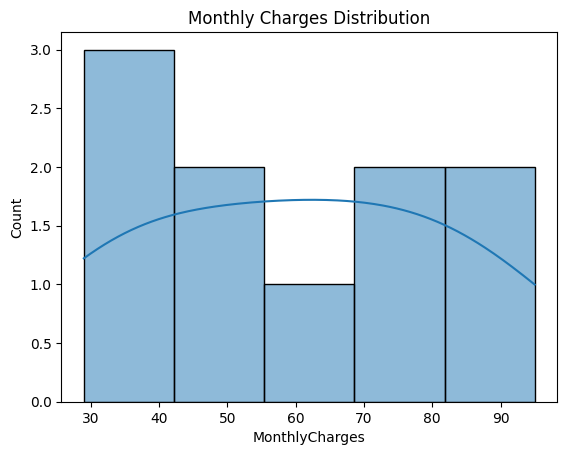

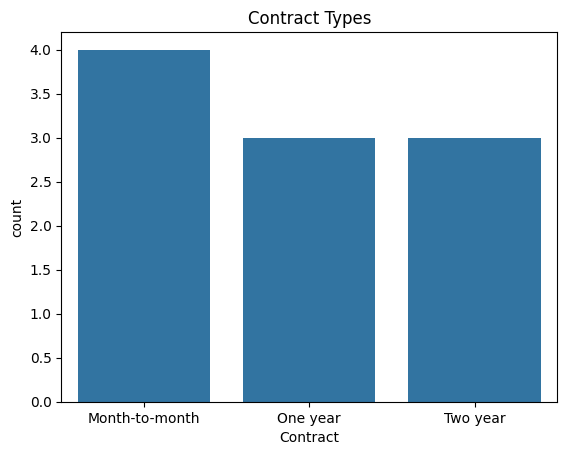

In [6]:
sns.histplot(df["MonthlyCharges"], kde=True)
plt.title("Monthly Charges Distribution")
plt.show()

sns.countplot(x="Contract", data=df)
plt.title("Contract Types")
plt.show()

### Feature selection (SelectKBest)

In [8]:
selector = SelectKBest(score_func=f_classif, k=3)
selector.fit(X, y)
print("\nTop features (SelectKBest):", X.columns[selector.get_support()].tolist())


Top features (SelectKBest): ['MonthlyCharges', 'Contract_One year', 'Contract_Two year']


###  Recursive Feature Elimination (RFE)

In [8]:
model = DecisionTreeClassifier()
rfe = RFE(model, n_features_to_select=3)
rfe.fit(X, y)
print("RFE Selected Features:", X.columns[rfe.support_].tolist())

RFE Selected Features: ['MonthlyCharges', 'Contract_One year', 'Contract_Two year']


### PCA (reduce to 2D for visualization)

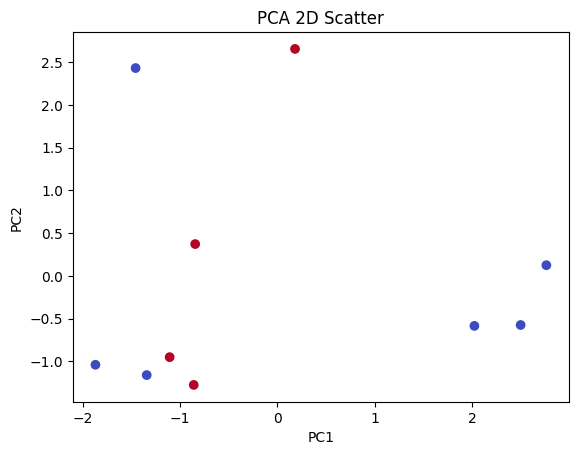

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="coolwarm")
plt.title("PCA 2D Scatter")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

### LDA

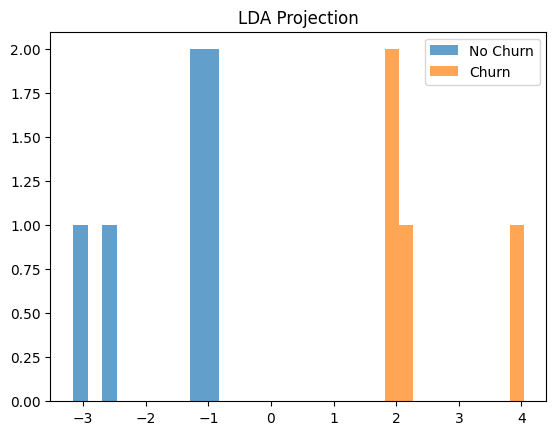

In [10]:
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_scaled, y)

plt.hist(X_lda[y==0], alpha=0.7, label="No Churn")
plt.hist(X_lda[y==1], alpha=0.7, label="Churn")
plt.title("LDA Projection")
plt.legend()
plt.show()

###  Handle imbalance with SMOTE

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
print("Before SMOTE:", y_train.value_counts())

sm = SMOTE(sampling_strategy='auto', k_neighbors=2)
X_res, y_res = sm.fit_resample(X_train, y_train)
print("After SMOTE:", pd.Series(y_res).value_counts())

Before SMOTE: Churn
0    4
1    3
Name: count, dtype: int64
After SMOTE: Churn
0    4
1    4
Name: count, dtype: int64


### Scale data

In [14]:
scaler = StandardScaler()
X_res_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.transform(X_test)

### Save processed dataset

In [15]:
processed = pd.DataFrame(X_res_scaled, columns=X.columns)
processed["Churn"] = y_res
processed.to_csv("processed_churn.csv", index=False)
print("Processed dataset saved as processed_churn.csv")

Processed dataset saved as processed_churn.csv
